In [1]:
from collections import namedtuple
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

# 横型ブラインドの斜入射特性を計算するモジュール

スラット材の形状とスラットの日射反射率から任意のプロファイル角における横型ブラインドの日射透過率及び日射反射率を計算する。

### 入力値  

$ W $ ：スラット幅 (m)  
$ d $ ：スラット高さ (m)  
$ S $ ：スラット間隔 (m)  
$ \rho_{upper,S} $：スラット材上面の日射反射率（鏡面反射成分）  
$ \rho_{upper,D} $：スラット材上面の日射反射率（拡散反射成分）  
$ \rho_{lower,S} $：スラット材下面の日射反射率（鏡面反射成分）  
$ \rho_{lower,D} $：スラット材下面の日射反射率（拡散反射成分）  
$ \psi $：スラット角 (°)  
$ \phi $：プロファイル角 (°)  

### 出力値
$ \tau_{\phi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$の日射透過率  
$ \tau_{\phi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$の日射透過率  
$ \rho_{\phi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$の日射反射率  
$ \rho_{\phi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$の日射反射率

### 計算方法  

#### データ構造と値の範囲  

$ W $・$ d $・$ S $・$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $・$ \psi $・$ \phi $の組み合わせをクラス『hbl＿input』と定義する。  
$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $の値は0.0以上1.0以下の値をとる。  
$ \psi $・$ \phi $の値は-90°以上90°以下の値をとる。  

In [2]:
class hbl_input():
    def __init__( self, W, d, S, REFUS, REFUD, REFLS, REFLD, psi, phi ):
        self.W = W
        self.d = d
        self.S = S
        self.REFUS = REFUS
        self.REFUD = REFUD
        self.REFLS = REFLS
        self.REFLD = REFLD
        self.psi = psi
        self.phi = phi

# W：スラット幅 (mm)
# d：スラット高さ (mm) 
# S：スラット間隔 (mm) 
# REFUS：スラット材上面の日射反射率（鏡面反射成分）
# REFUD：スラット材上面の日射反射率（拡散反射成分）
# REFLS：スラット材下面の日射反射率（鏡面反射成分）
# REFLD：スラット材下面の日射反射率（拡散反射成分）
# psi：スラット角 (°) 
# phi：プロファイル角 (°)

$ \begin{align} Q_{m,(0)} = I･\cos \phi･\Delta L_{m} \end{align}$ ････････････････････････････････････････････ (1)

### 1. 鏡面反射

#### 光線の方向ベクトルの計算  

（参考：JIS A 2103：2014 附属書C ブラインドの光学特性の計算方法）  

光線の方向ベクトル$ \boldsymbol{s}_{(l)} $の計算式  
$ \begin{align}\boldsymbol{s}_{(l)} = \boldsymbol{s}_{(l-1)} + 2 \frac{\boldsymbol{s}_{(l-1)}･\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|} \frac{\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|}\end{align}$ ･･････････････････････ (C.5)  

（式(C.5)の補足説明）  

$ \begin{align}c = \bigl|\boldsymbol{s}_{(l-1)}\bigr| \cos \theta \end{align}$ ･･････････････････････ (1)  

内積の関係より、  

$ \begin{align}\cos \theta = \frac{\boldsymbol{s}_{(l-1)}･\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{s}_{(l-1)}\bigr|\bigl|\boldsymbol{v}_{(i)}\bigr|}\end{align}$ ･･････････････････････ (2)  

式(1)と式(2)より、

$ \begin{align}c = \frac{\boldsymbol{s}_{(l-1)}･\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|} \end{align}$ ･･････････････････････ (3)  

次に、  

$ \begin{align}\boldsymbol{s}_{(l)} = -\boldsymbol{s}_{(l-1)} + 2c\frac{\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|}\end{align}$ ･･････････････････････ (4)  

式(3)と式(4)より、  

$ \begin{align}\boldsymbol{s}_{(l)} = \boldsymbol{s}_{(l-1)} + 2 \frac{\boldsymbol{s}_{(l-1)}･\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|} \frac{\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|}\end{align}$ ･･････････････････････ (5)  

![image3.png][attached1]
[attached1]:img\image3.png  

0.0512 0.5056


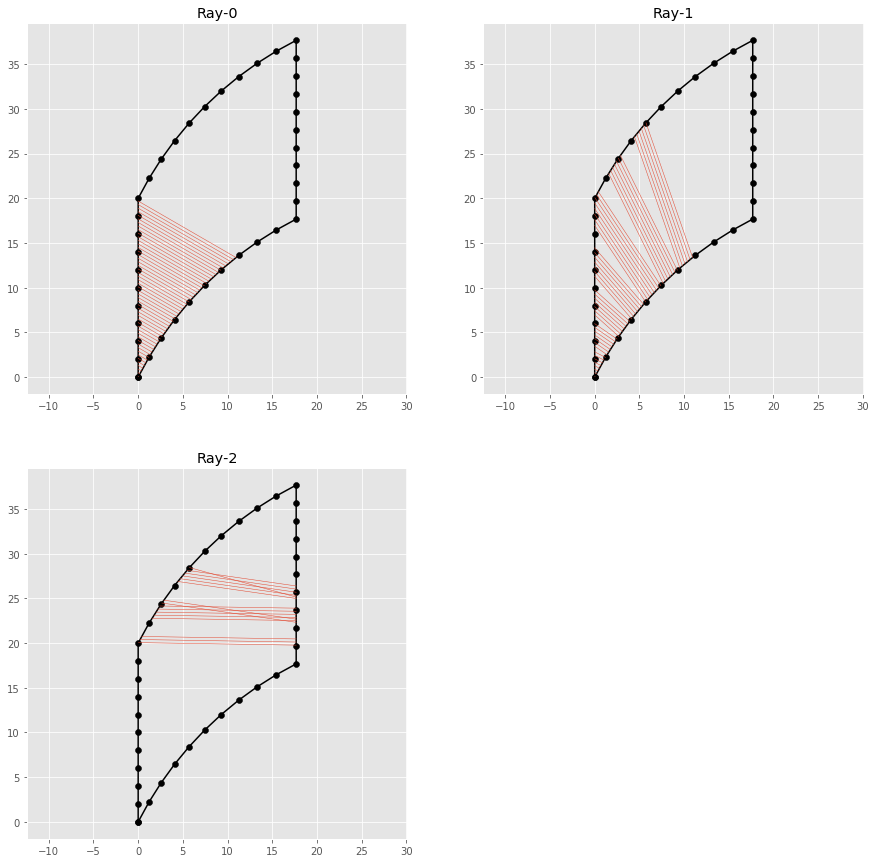

In [9]:
#1

S = 20.                              #スラット間隔(mm)
W = 25.                              #スラット幅(mm)
d = 2.                               #スラット高さ(mm)
psi = 45.                            #スラット角(°)
rho_upper = 0.8                      #スラット材上面の反射率(鏡面)
rho_lower = 0.2                      #スラット材下面の反射率(鏡面)
phi = 30.                            #プロファイル角(°)

M = 100                              #入射開口の微小線分要素分割数
K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)
Kall = np.sum(K)                     #領域境界の微小線分要素分割数(全境界)
L = 100                              #最大反射回数

#スラット高さがある場合のスラット円弧の計算
if d != 0:
    circle = np.empty((2, 3, 2), dtype=object)
    circle[0][0] = [0., 0.]                              #点A

    circle[0][1] = [W * np.cos(np.deg2rad(psi)), 
                    W * np.sin(np.deg2rad(psi))]       #点B

    circle[0][2] = [((W / 2) ** 2 + d ** 2) ** 0.5 * np.cos(np.arctan(d / (W / 2)) + np.deg2rad(psi)),
                    ((W / 2) ** 2 + d ** 2) ** 0.5 * np.sin(np.arctan(d / (W / 2)) + np.deg2rad(psi))]   #点F

    a = np.empty((3, 3), dtype=object)
    b = np.empty((3), dtype=object)
    x = np.empty((3), dtype=object)

    a[:, 0] = circle[0][:, 0]
    a[:, 1] = circle[0][:, 1]
    a[:, 2] = 1.
    b = -(circle[0][:, 0] ** 2. + circle[0][:, 1] ** 2.)

    a = a.astype(np.float64)
    b = b.astype(np.float64)

    x = np.linalg.solve(a,b)

    r = ((x[0] / 2) ** 2 + (x[1] / 2) ** 2 - x[2]) ** 0.5

    circle_o = [r * np.cos(np.deg2rad(90 - psi) - 2 * np.arctan(d / (W / 2))),
                -r * np.sin(np.deg2rad(90 - psi) - 2 * np.arctan(d / (W / 2)))]

    circle_theta = np.rad2deg(4 * np.arctan(d / (W / 2)))

#領域境界の分割要素の始点の位置ベクトル
q = np.empty((Kall + 1, 2), dtype=object)
for i in range(Kall + 1):
    if d == 0: #平板
        if i <= K[0]:                            #A-B間
            q[i] = [W / K[0] * i * np.cos(np.deg2rad(psi)), 
                    W / K[0] * i * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] - W / K[2] * (i - K[0] - K[1]) * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] - W / K[2] * (i - K[0] - K[1]) * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
    elif d != 0: #円弧
        if i <= K[0]:                            #A-B間
            q[i] = [circle_o[0] - r * np.cos((np.arctan(circle_o[1] / circle_o[0])) - np.deg2rad(circle_theta / K[0] * i)), 
                    circle_o[1] - r * np.sin((np.arctan(circle_o[1] / circle_o[0])) - np.deg2rad(circle_theta / K[0] * i))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] + \
                    circle_o[0] - r * np.cos((np.arctan(circle_o[1] / circle_o[0])) - np.deg2rad(circle_theta) + \
                    np.deg2rad(circle_theta / K[2] * (i - K[0] - K[1]))) - W * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] + \
                    circle_o[1] - r * np.sin((np.arctan(circle_o[1] / circle_o[0])) - np.deg2rad(circle_theta) + \
                    np.deg2rad(circle_theta / K[2] * (i - K[0] - K[1]))) - W * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
        
#領域境界の分割要素の方向ベクトル
v = np.empty((Kall, 2), dtype=object)
for i in range(Kall):
    v[i] = [q[i+1][0] - q[i][0], q[i+1][1] - q[i][1]]

l = 0
p = np.empty((M, L, 2), dtype=object)
s = np.empty((M, L, 2), dtype=object)
ipi = np.empty((M, L), dtype=object)
rc_upper = np.zeros(M)
rc_lower = np.zeros(M)
dir_ray = np.empty(M)
while l <= 10 and not (s[:,l-1] == 0).all():
    for m in range(M):
        if l == 0:
            #日射の始点の位置ベクトル(0回目)
            p[m][l] = [0, S / M * (m + 0.5)]            
            #日射の方向ベクトル(0回目)
            s[m][l] = [np.cos(np.deg2rad(phi)), -np.sin(np.deg2rad(phi))]
        elif l > 0:
            #日射の方向ベクトル(1回目以降)
            if (K[0] <= ipi[m][l-1] and ipi[m][l-1] <= (K[0] + K[1])):
                dir_ray[m] = 1 #透過
                s[m][l] = 0
            elif  ((K[0] + K[1] + K[2]) <= ipi[m][l-1] and ipi[m][l-1] <= Kall):
                dir_ray[m] = 0 #反射
                s[m][l] = 0
            else:
                s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ipi[m][l-1]]) * v[ipi[m][l-1]] / \
                          (v[ipi[m][l-1]][0] ** 2. + v[ipi[m][l-1]][1] ** 2.)

    for m in range(M):
        for i in range(Kall):
            if (s[m][l] == 0).all():
                p[m][l + 1] = p[m][l]
                ipi[m][l] = ipi[m][l-1]
            else:
                if l == 0 or (l > 0 and i != ipi[m][l-1]):
                    deno = v[i][1] * s[m][l][0] - v[i][0] * s[m][l][1]
                    if deno != 0:
                        a = (v[i][0] * (p[m][l][1] - q[i][1]) - v[i][1] * (p[m][l][0] - q[i][0])) / deno
                        b = (s[m][l][0] * (p[m][l][1] - q[i][1]) - s[m][l][1] * (p[m][l][0] - q[i][0])) / deno

                        if 0 < a and 0 <= b and b < 1:
                            p[m][l + 1] = q[i] + b * v[i]
                            ipi[m][l] = i
                            if 0 <= i and i <= K[0]:
                                rc_upper[m] += 1
                            elif (K[0] + K[1]) <= i and i <= (K[0] + K[1] + K[2]):
                                rc_lower[m] += 1

    l += 1

attenuation = np.zeros(M)
for m in range(M):
    attenuation[m] = rho_upper ** rc_upper[m] * rho_lower ** rc_lower[m]

tau_tot = 0.
rho_tot = 0.
for m in range(M):
    tau_tot += attenuation[m] * dir_ray[m] / M #透過
    rho_tot += attenuation[m] * (1 - dir_ray[m]) / M #反射

print(tau_tot, rho_tot)

#グラフの描画
gx = np.empty((M, L, 2), dtype=object)
gy = np.empty((M, L, 2), dtype=object)
for ll in range(l):
    for m in range(0, M, 2):
        gx[m][ll] = [p[m][ll][0], p[m][ll + 1][0]]
        gy[m][ll] = [p[m][ll][1], p[m][ll + 1][1]]    

ax = np.empty(l, dtype = np.object) #
fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2))) #
#fig = plt.figure(figsize = (10, 10))
plt.style.use('ggplot')
#plt.tick_params(labelsize=10)

for ll in range(l-1):   
    ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
    #ax = fig.add_subplot(1, 1, 1)
    ax[ll].set_title('Ray-' + str(ll))
    ax[ll].scatter(q[:, 0], q[:, 1], color='k')
    ax[ll].plot(q[:, 0], q[:, 1], color='k')
    for m in range(M):
        ax[ll].plot(gx[m][ll], gy[m][ll], color='C0', linewidth=0.5)
    #ax.scatter(p[:, 1, 0], p[:, 1, 1], color='C0')
    plt.axis('equal')

plt.show()


#### 円弧スラットの微小線分要素の位置ベクトルと方向ベクトルの計算  


円の方程式

$\begin{align}x^2 + y^2 + l_0x + l_1y + l_2 = 0\end{align}$ ･･････････････････････ (1)  

式(1)を変形すると

$\begin{align}l_0x + l_1y + l_2 = -(x^2 + y^2)\end{align}$ ･･････････････････････ (2)  

点A、点B、点Fの3点の座標を通る外接円について考える。

それぞれの位置ベクトルは、次のように表すことができる。

$ 
\boldsymbol{A} = 
\begin{pmatrix} 
0 \\
0 \\
\end{pmatrix} 
$、
$ 
\boldsymbol{B} = 
\begin{pmatrix} 
W\cos\psi \\
W\sin\psi \\
\end{pmatrix} 
$、
$ 
\boldsymbol{F} = 
\begin{pmatrix} 
\sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\end{pmatrix} 
$

3点の位置ベクトルを式(2)に代入して連立すると
               
$\begin{align}\boldsymbol{a}･\boldsymbol{l} = \boldsymbol{b}\end{align}$ ･･････････････････････ (3)
                      
ここで、

$ 
\boldsymbol{a} = 
\begin{pmatrix} 
0&0&1 \\
W\cos\psi&W\sin\psi&1 \\
\sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} +\psi\Bigr)&\sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)&1 \\
\end{pmatrix} 
$


$
\boldsymbol{l}
=
\begin{pmatrix} 
l_0 \\
l_1 \\
l_2 \\
\end{pmatrix}
$

$
\boldsymbol{b}
= 
\begin{pmatrix} 
0 \\
-(W\cos\psi^2 + \sin\psi^2) \\
-\Biggl(\biggl(\sqrt{(0.5W)^2 + d^2}\cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2 + 
        \biggl(\sqrt{(0.5W)^2 + d^2}\sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2\Biggr) \\
\end{pmatrix} 
$  

外接円の中心点Gの位置ベクトルは、次のように表すことができる。  

$ 
\boldsymbol{G} = 
\begin{pmatrix} 
-0.5l_0 \\
-0.5l_1 \\
\end{pmatrix} 
$

外接円の半径$r$は、 

$\begin{align}r = \sqrt{(-0.5l_0) ^ 2 + (-0.5l_1) ^ 2 - l_2} \end{align}$ ･･････････････････････ (4)



円弧の領域境界の微小要素の位置ベクトルは、次のように表すことができる。  

$0 \leq i \leq K_0$の場合、  

$ 
\boldsymbol{q}_i = 
\begin{pmatrix} 
\boldsymbol{G}_x - r \cos\Bigl(\arctan\frac{\boldsymbol{G}_y}{\boldsymbol{G}_x} - \frac{i}{K_0}\theta\Bigr) \\
\boldsymbol{G}_y - r \sin\Bigl(\arctan\frac{\boldsymbol{G}_y}{\boldsymbol{G}_x} - \frac{i}{K_0}\theta\Bigr) \\
\end{pmatrix} 
$

$K_0 < i \leq (K_0 + K_1)$の場合、  

$ 
\boldsymbol{q}_i = 
\begin{pmatrix} 
\boldsymbol{q}_{K_0,x} \\
\boldsymbol{q}_{K_0,y} - \frac{i - K_0}{K_1}S \\
\end{pmatrix} 
$

$(K_0 + K_1) < i \leq (K_0 + K_1 + K_2)$の場合、  

$ 
\boldsymbol{q}_i = 
\begin{pmatrix} 
\boldsymbol{q}_{(K_0 + K_1),x} + \boldsymbol{G}_x - r\cos\Bigl(\arctan\frac{\boldsymbol{G}_y}{\boldsymbol{G}_x} + \frac{i - K_0 - K_1 - K_2}{K_2}\theta\Bigr) - W\cos\psi \\
\boldsymbol{q}_{(K_0 + K_1),y} + \boldsymbol{G}_y - r\sin\Bigl(\arctan\frac{\boldsymbol{G}_y}{\boldsymbol{G}_x} + \frac{i - K_0 - K_1 - K_2}{K_2}\theta\Bigr) - W\sin\psi \\
\end{pmatrix} 
$

$(K_0 + K_1 + K_2) < i \leq (K_0 + K_1 + K_2 + K_3)$の場合、  

$ 
\boldsymbol{q}_i = 
\begin{pmatrix} 
\boldsymbol{q}_{(K_0 + K_1 + K_2),x} \\
\boldsymbol{q}_{(K_0 + K_1 + K_2),y} - \frac{i - K_0 - K_1 - K_2}{K_3}S \\
\end{pmatrix} 
$


0.0512 0.5056


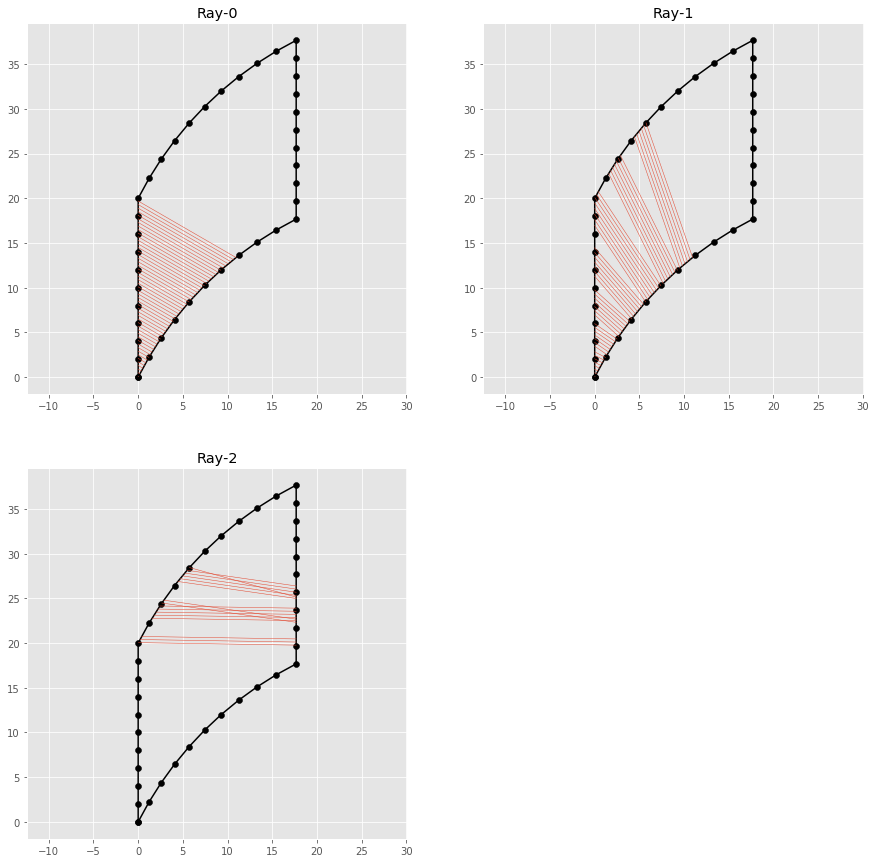

In [6]:
#2

S = 20.                              #スラット間隔(mm)
W = 25.                              #スラット幅(mm)
d = 2.                               #スラット高さ(mm)
psi = 45.                            #スラット角(°)
rho_upper = 0.8                      #スラット材上面の反射率(鏡面)
rho_lower = 0.2                      #スラット材下面の反射率(鏡面)
phi = 30.                            #プロファイル角(°)

M = 100                              #入射開口の微小線分要素分割数
K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)
Kall = np.sum(K)                     #領域境界の微小線分要素分割数(全境界)
L = 100                              #最大反射回数

#スラット高さがある場合のスラット円弧の計算
if d != 0:
    cir_a = np.empty((3, 3), dtype=object)
    cir_b = np.empty((3), dtype=object)
    cir_l = np.empty((3), dtype=object)
    
    cir_a = np.array([[0., 0., 1.],
                     [W * np.cos(np.deg2rad(psi)), W * np.sin(np.deg2rad(psi)), 1.],
                     [((W / 2) ** 2 + d ** 2) ** 0.5 * np.cos(np.arctan(d / (W / 2)) + np.deg2rad(psi)), 
                      ((W / 2) ** 2 + d ** 2) ** 0.5 * np.sin(np.arctan(d / (W / 2)) + np.deg2rad(psi)), 1.]])
    
    cir_b = -(cir_a[:, 0] ** 2 + cir_a[:, 1] ** 2)

    cir_a = cir_a.astype(np.float64)
    cir_b = cir_b.astype(np.float64)
    cir_l = np.linalg.solve(cir_a, cir_b)
    
    cir_r = ((cir_l[0] / 2) ** 2 + (cir_l[1] / 2) ** 2 - cir_l[2]) ** 0.5

    cir_o = [cir_r * np.cos(np.deg2rad(90 - psi) - 2 * np.arctan(d / (W / 2))),
             -cir_r * np.sin(np.deg2rad(90 - psi) - 2 * np.arctan(d / (W / 2)))]

    cir_theta = np.rad2deg(4 * np.arctan(d / (W / 2)))
    
#領域境界の分割要素の始点の位置ベクトル
q = np.empty((Kall + 1, 2), dtype=object)
for i in range(Kall + 1):
    if d == 0: #平板
        if i <= K[0]:                            #A-B間
            q[i] = [W / K[0] * i * np.cos(np.deg2rad(psi)), 
                    W / K[0] * i * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] - W / K[2] * (i - K[0] - K[1]) * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] - W / K[2] * (i - K[0] - K[1]) * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
    elif d != 0: #円弧
        if i <= K[0]:                            #A-B間
            q[i] = [cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i)), 
                    cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] + cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) + \
                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1] - K[2]))) - W * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] + cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) + \
                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1] - K[2]))) - W * np.sin(np.deg2rad(psi))]

#                    cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta) + \
#                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1]))) - W * np.cos(np.deg2rad(psi)), 
#                    q[K[0] + K[1]][1] + \
#                    cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta) + \
#                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1]))) - W * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
        
#領域境界の分割要素の方向ベクトル
v = np.empty((Kall, 2), dtype=object)
for i in range(Kall):
    v[i] = [q[i+1][0] - q[i][0], q[i+1][1] - q[i][1]]

l = 0
p = np.empty((M, L, 2), dtype=object)
s = np.empty((M, L, 2), dtype=object)
ipi = np.empty((M, L), dtype=object)
rc_upper = np.zeros(M)
rc_lower = np.zeros(M)
dir_ray = np.empty(M)
while l <= 10 and not (s[:,l-1] == 0).all():
    for m in range(M):
        if l == 0:
            #日射の始点の位置ベクトル(0回目)
            p[m][l] = [0, S / M * (m + 0.5)]            
            #日射の方向ベクトル(0回目)
            s[m][l] = [np.cos(np.deg2rad(phi)), -np.sin(np.deg2rad(phi))]
        elif l > 0:
            #日射の方向ベクトル(1回目以降)
            if (K[0] <= ipi[m][l-1] and ipi[m][l-1] <= (K[0] + K[1])):
                dir_ray[m] = 1 #透過
                s[m][l] = 0
            elif  ((K[0] + K[1] + K[2]) <= ipi[m][l-1] and ipi[m][l-1] <= Kall):
                dir_ray[m] = 0 #反射
                s[m][l] = 0
            else:
                s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ipi[m][l-1]]) * v[ipi[m][l-1]] / \
                          (v[ipi[m][l-1]][0] ** 2. + v[ipi[m][l-1]][1] ** 2.)

    for m in range(M):
        for i in range(Kall):
            if (s[m][l] == 0).all():
                p[m][l + 1] = p[m][l]
                ipi[m][l] = ipi[m][l-1]
            else:
                if l == 0 or (l > 0 and i != ipi[m][l-1]):
                    deno = v[i][1] * s[m][l][0] - v[i][0] * s[m][l][1]
                    if deno != 0:
                        a = (v[i][0] * (p[m][l][1] - q[i][1]) - v[i][1] * (p[m][l][0] - q[i][0])) / deno
                        b = (s[m][l][0] * (p[m][l][1] - q[i][1]) - s[m][l][1] * (p[m][l][0] - q[i][0])) / deno

                        if 0 < a and 0 <= b and b < 1:
                            p[m][l + 1] = q[i] + b * v[i]
                            ipi[m][l] = i
                            if 0 <= i and i <= K[0]:
                                rc_upper[m] += 1
                            elif (K[0] + K[1]) <= i and i <= (K[0] + K[1] + K[2]):
                                rc_lower[m] += 1

    l += 1

attenuation = np.zeros(M)
for m in range(M):
    attenuation[m] = rho_upper ** rc_upper[m] * rho_lower ** rc_lower[m]

tau_tot = 0.
rho_tot = 0.
for m in range(M):
    tau_tot += attenuation[m] * dir_ray[m] / M #透過
    rho_tot += attenuation[m] * (1 - dir_ray[m]) / M #反射

print(tau_tot, rho_tot)

#グラフの描画
gx = np.empty((M, L, 2), dtype=object)
gy = np.empty((M, L, 2), dtype=object)
for ll in range(l):
    for m in range(0, M, 2):
        gx[m][ll] = [p[m][ll][0], p[m][ll + 1][0]]
        gy[m][ll] = [p[m][ll][1], p[m][ll + 1][1]]    

ax = np.empty(l, dtype = np.object) #
fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2))) #
#fig = plt.figure(figsize = (10, 10))
plt.style.use('ggplot')
#plt.tick_params(labelsize=10)

for ll in range(l-1):   
    ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
    #ax = fig.add_subplot(1, 1, 1)
    ax[ll].set_title('Ray-' + str(ll))
    ax[ll].scatter(q[:, 0], q[:, 1], color='k')
    ax[ll].plot(q[:, 0], q[:, 1], color='k')
    for m in range(M):
        ax[ll].plot(gx[m][ll], gy[m][ll], color='C0', linewidth=0.5)
    #ax.scatter(p[:, 1, 0], p[:, 1, 1], color='C0')
    plt.axis('equal')

plt.show()


T+ 7.25714337867445 0.0
0.0 0.880000000000001


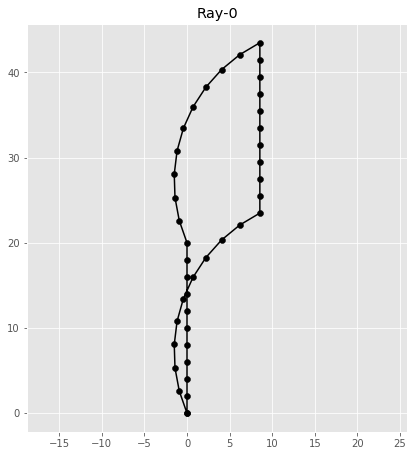

A= [[ 0.          0.          1.        ]
 [ 8.55050358 23.49231552  1.        ]
 [-0.42321131 13.45625848  1.        ]]
B= [  -0.   -625.   -181.25]
l= [-33.21743488 -14.51428676   0.        ]
O= [16.60871743938591, 7.25714337867445]
r= 18.125
θ= 87.20563794540725


In [13]:
#3

S = 20.                              #スラット間隔(mm)
W = 25.                              #スラット幅(mm)
d = 5.                               #スラット高さ(mm)
psi = 70.                            #スラット角(°)
rho_upper = 0.8                      #スラット材上面の反射率(鏡面)
rho_lower = 0.2                      #スラット材下面の反射率(鏡面)
phi = 30.                            #プロファイル角(°)

M = 100                              #入射開口の微小線分要素分割数
K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)
Kall = np.sum(K)                     #領域境界の微小線分要素分割数(全境界)
L = 100                              #最大反射回数

#スラット高さがある場合のスラット円弧の計算
if d != 0:
    cir_a = np.empty((3, 3), dtype=object)
    cir_b = np.empty((3), dtype=object)
    cir_l = np.empty((3), dtype=object)
    
    cir_a = np.array([[0., 0., 1.],
                     [W * np.cos(np.deg2rad(psi)), W * np.sin(np.deg2rad(psi)), 1.],
                     [((W / 2) ** 2 + d ** 2) ** 0.5 * np.cos(np.arctan(d / (W / 2)) + np.deg2rad(psi)), 
                      ((W / 2) ** 2 + d ** 2) ** 0.5 * np.sin(np.arctan(d / (W / 2)) + np.deg2rad(psi)), 1.]])
    
    cir_b = -(cir_a[:, 0] ** 2 + cir_a[:, 1] ** 2)

    cir_a = cir_a.astype(np.float64)
    cir_b = cir_b.astype(np.float64)
    cir_l = np.linalg.solve(cir_a, cir_b)
    
    cir_o =[- 0.5 * cir_l[0], - 0.5 * cir_l[1]]
    cir_r = ((- 0.5 * cir_l[0]) ** 2 + (- 0.5 * cir_l[1]) ** 2 - cir_l[2]) ** 0.5

    cir_theta = np.rad2deg(4 * np.arctan(d / (W / 2)))

    if psi > 0:
        if cir_o[1] > cir_a[0][1]:
            print("T+", cir_o[1], cir_a[0][1])
    elif psi < 0:
        if cir_o[1] > cir_a[0][1]:
            print("T-", cir_o[1], cir_a[0][1])

    
#領域境界の分割要素の始点の位置ベクトル
q = np.empty((Kall + 1, 2), dtype=object)
for i in range(Kall + 1):
    if d == 0: #平板
        if i <= K[0]:                            #A-B間
            q[i] = [W / K[0] * i * np.cos(np.deg2rad(psi)), 
                    W / K[0] * i * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] - W / K[2] * (i - K[0] - K[1]) * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] - W / K[2] * (i - K[0] - K[1]) * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
    elif d != 0: #円弧
        if i <= K[0]:                            #A-B間
            q[i] = [cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i)), 
                    cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] + cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) + \
                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1] - K[2]))) - W * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] + cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) + \
                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1] - K[2]))) - W * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
        
#領域境界の分割要素の方向ベクトル
v = np.empty((Kall, 2), dtype=object)
for i in range(Kall):
    v[i] = [q[i+1][0] - q[i][0], q[i+1][1] - q[i][1]]

l = 0
p = np.empty((M, L, 2), dtype=object)
s = np.empty((M, L, 2), dtype=object)
ipi = np.empty((M, L), dtype=object)
rc_upper = np.zeros(M)
rc_lower = np.zeros(M)
dir_ray = np.empty(M)
while l <= 10 and not (s[:,l-1] == 0).all():
    for m in range(M):
        if l == 0:
            #日射の始点の位置ベクトル(0回目)
            p[m][l] = [0, S / M * (m + 0.5)]            
            #日射の方向ベクトル(0回目)
            s[m][l] = [np.cos(np.deg2rad(phi)), -np.sin(np.deg2rad(phi))]
        elif l > 0:
            #日射の方向ベクトル(1回目以降)
            if (K[0] <= ipi[m][l-1] and ipi[m][l-1] <= (K[0] + K[1])):
                dir_ray[m] = 1 #透過
                s[m][l] = 0
            elif  ((K[0] + K[1] + K[2]) <= ipi[m][l-1] and ipi[m][l-1] <= Kall):
                dir_ray[m] = 0 #反射
                s[m][l] = 0
            else:
                s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ipi[m][l-1]]) * v[ipi[m][l-1]] / \
                          (v[ipi[m][l-1]][0] ** 2. + v[ipi[m][l-1]][1] ** 2.)

    for m in range(M):
        for i in range(Kall):
            if (s[m][l] == 0).all():
                p[m][l + 1] = p[m][l]
                ipi[m][l] = ipi[m][l-1]
            else:
                if l == 0 or (l > 0 and i != ipi[m][l-1]):
                    deno = v[i][1] * s[m][l][0] - v[i][0] * s[m][l][1]
                    if deno != 0:
                        a = (v[i][0] * (p[m][l][1] - q[i][1]) - v[i][1] * (p[m][l][0] - q[i][0])) / deno
                        b = (s[m][l][0] * (p[m][l][1] - q[i][1]) - s[m][l][1] * (p[m][l][0] - q[i][0])) / deno

                        if 0 < a and 0 <= b and b < 1:
                            p[m][l + 1] = q[i] + b * v[i]
                            ipi[m][l] = i
                            if 0 <= i and i <= K[0]:
                                rc_upper[m] += 1
                            elif (K[0] + K[1]) <= i and i <= (K[0] + K[1] + K[2]):
                                rc_lower[m] += 1

    l += 1

attenuation = np.zeros(M)
for m in range(M):
    attenuation[m] = rho_upper ** rc_upper[m] * rho_lower ** rc_lower[m]

tau_tot = 0.
rho_tot = 0.
for m in range(M):
    tau_tot += attenuation[m] * dir_ray[m] / M #透過
    rho_tot += attenuation[m] * (1 - dir_ray[m]) / M #反射

print(tau_tot, rho_tot)

#グラフの描画
gx = np.empty((M, L, 2), dtype=object)
gy = np.empty((M, L, 2), dtype=object)
for ll in range(l):
    for m in range(0, M, 2):
        gx[m][ll] = [p[m][ll][0], p[m][ll + 1][0]]
        gy[m][ll] = [p[m][ll][1], p[m][ll + 1][1]]    

ax = np.empty(l, dtype = np.object) #
fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2))) #
#fig = plt.figure(figsize = (10, 10))
plt.style.use('ggplot')
#plt.tick_params(labelsize=10)

for ll in range(l-1):   
    ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
    #ax = fig.add_subplot(1, 1, 1)
    ax[ll].set_title('Ray-' + str(ll))
    ax[ll].scatter(q[:, 0], q[:, 1], color='k')
    ax[ll].plot(q[:, 0], q[:, 1], color='k')
    for m in range(M):
        ax[ll].plot(gx[m][ll], gy[m][ll], color='C0', linewidth=0.5)
    #ax.scatter(p[:, 1, 0], p[:, 1, 1], color='C0')
    plt.axis('equal')

plt.show()

print('A=', cir_a)
print('B=', cir_b)
print('l=', cir_l)
print('O=', cir_o)
print('r=', cir_r)
print('θ=', cir_theta)

### 作成中

#### スラット端点と中央点の位置

点A(下スラットの左端点)、点B(下スラットの右端点)、点C(上スラットの右端点)、点D(上スラットの左端点)、点E(下スラットの中央点)、点F(上スラットの中央点)の位置ベクトルは、

$$ 
\displaystyle \boldsymbol{A} = 
\begin{pmatrix} 
\displaystyle 0 \\
\displaystyle 0 \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

$$ 
\displaystyle \boldsymbol{B} = 
\begin{pmatrix} 
\displaystyle W\cos\psi \\
\displaystyle W\sin\psi \\
\end{pmatrix} 
\qquad\qquad\text{(2)}
$$

$$ 
\displaystyle \boldsymbol{C} = 
\begin{pmatrix} 
\displaystyle \boldsymbol{B}_{x} \\
\displaystyle \boldsymbol{B}_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(3)}
$$

$$ 
\displaystyle \boldsymbol{D} = 
\begin{pmatrix} 
\displaystyle \boldsymbol{A}_{x} \\
\displaystyle \boldsymbol{A}_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(4)}
$$

平板スラット($d=0$)の場合、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{E} = \frac{\boldsymbol{B} - \boldsymbol{A}}{2}& \qquad\qquad\text{(5)} \nonumber\\
\end{eqnarray}
$$

円弧スラット($d \neq 0$)の場合、

$$ 
\displaystyle \boldsymbol{E} = 
\begin{pmatrix} 
\displaystyle \sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\displaystyle \sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\end{pmatrix} 
\qquad\qquad\text{(6)}
$$

$$ 
\displaystyle \boldsymbol{F} = 
\begin{pmatrix} 
\displaystyle \boldsymbol{E}_{x} \\
\displaystyle \boldsymbol{E}_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(7)}
$$

In [9]:
def slat_edge_position(L):
    
    A = np.array([0., 0.]) #式(1)
    B = np.array([L.W * np.cos(np.deg2rad(L.psi)), L.W * np.sin(np.deg2rad(L.psi))]) #式(2)
    C = np.array([B[0], B[1] + L.S]) #式(3)
    D = np.array([A[0], A[1] + L.S]) #式(4)
    if L.d ==0:
        E = (B - A) / 2. #式(5)
        print(E)
    else:
        E = np.array([((0.5 * L.W) ** 2. + L.d ** 2.) ** 0.5 * np.cos(np.arctan(L.d / (0.5 * L.W)) + np.deg2rad(L.psi)), 
                      ((0.5 * L.W) ** 2. + L.d ** 2.) ** 0.5 * np.sin(np.arctan(L.d / (0.5 * L.W)) + np.deg2rad(L.psi))]) #式(6)
    
    F = np.array([E[0], E[1] + L.S]) #式(7)
    
    return A, B, C, D, E, F

#### 円弧スラットの中心座標、半径、中心角  

円弧スラット($d \neq 0$)の場合、  

円の方程式  

$$
\begin{eqnarray}
 &\displaystyle x^2 + y^2 + l_0x + l_1y + l_2 = 0& \qquad\qquad\text{(1)} \nonumber\\
\end{eqnarray}
$$

式(1)を変形すると、  

$$
\begin{eqnarray}
 &\displaystyle l_0x + l_1y + l_2 = -(x^2 + y^2)& \qquad\qquad\text{(2)} \nonumber\\
\end{eqnarray}
$$

外接円となる点A、点B、点Eの3点の位置ベクトルを式(2)に代入して連立すると、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{a} \cdot \boldsymbol{l} = \boldsymbol{b}& \qquad\qquad\text{(3)} \nonumber\\
\end{eqnarray}
$$

ここで、

$ 
\displaystyle \boldsymbol{a} = 
\begin{pmatrix} 
\displaystyle 0&\displaystyle 0&\displaystyle 1 \\
\displaystyle W\cos\psi&\displaystyle W\sin\psi&\displaystyle 1 \\
\displaystyle \sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} +\psi\Bigr)&\displaystyle \sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)&\displaystyle 1 \\
\end{pmatrix} 
$  

$
\displaystyle \boldsymbol{l}
=
\begin{pmatrix} 
\displaystyle l_0 \\
\displaystyle l_1 \\
\displaystyle l_2 \\
\end{pmatrix}
$  

$
\displaystyle \boldsymbol{b}
= 
\begin{pmatrix} 
\displaystyle 0 \\
\displaystyle -(W\cos\psi^2 + \sin\psi^2) \\
\displaystyle -\Biggl(\biggl(\sqrt{(0.5W)^2 + d^2}\cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2 + 
               \biggl(\sqrt{(0.5W)^2 + d^2}\sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2\Biggr) \\
\end{pmatrix} 
$  

外接円の中心点Oの位置ベクトルは、

$$ 
\displaystyle \boldsymbol{O} = 
\begin{pmatrix} 
\displaystyle -0.5l_0 \\
\displaystyle -0.5l_1 \\
\end{pmatrix}
\qquad\qquad\text{(4)}
$$

外接円の半径$r$は、

$$
\begin{eqnarray}
 &\displaystyle r = \sqrt{(-0.5l_0) ^ 2 + (-0.5l_1) ^ 2 - l_2}& \qquad\qquad\text{(5)} \nonumber\\
\end{eqnarray}
$$

点Aと点Bがなす円弧の中心角$\theta$は、

$$
\begin{eqnarray}
 &\displaystyle \theta = 4 \arctan \frac{d}{0.5W}& \qquad\qquad\text{(6)} \nonumber\\
\end{eqnarray}
$$

In [28]:
#3点を通る外接円の点A、点B、点E及び中心点Oの座標、半径r、中心角θ
def slat_circle(L, A, B, E):
    
    if L.d == 0:
        O = ''
        r = ''
        theta = ''
    else:
        a = np.array([[A[0], A[1], 1.], [B[0], B[1], 1.], [E[0], E[1], 1.]])
        b = -(a[:, 0] ** 2 + a[:, 1] ** 2.)

        a = a.astype(np.float64)
        b = b.astype(np.float64)
        l = np.linalg.solve(a, b) #式(3)

        O =[- 0.5 * l[0], - 0.5 * l[1]] #円弧の原点の位置ベクトル 式(4)
        r = ((- 0.5 * l[0]) ** 2. + (- 0.5 * l[1]) ** 2. - l[2]) ** 0.5 #式(5)
        theta = np.rad2deg(4 * np.arctan(L.d / (0.5 * L.W))) #円弧の中心角 式(6)
    
    return O, r, theta

#### スラットの最端座標  

円弧スラット($d \neq 0$)かつ$ \boldsymbol{O}_{y} > \boldsymbol{A}_{y} $の場合、 

$$ 
\displaystyle \boldsymbol{A}' = 
\begin{pmatrix} 
\displaystyle \boldsymbol{O}_{x} - r \\
\displaystyle \boldsymbol{O}_{y} \\
\end{pmatrix}
\qquad\qquad\text{(1)}
$$

円弧スラット($d \neq 0$)かつ$ \boldsymbol{O}_{y} > \boldsymbol{B}_{y} $の場合、 

$$ 
\displaystyle \boldsymbol{B}' = 
\begin{pmatrix} 
\displaystyle \boldsymbol{O}_{x} + r \\
\displaystyle \boldsymbol{O}_{y} \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

その他の場合、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{A}' = \boldsymbol{A}& \qquad\qquad\text{(3)} \nonumber\\
\end{eqnarray}
$$

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{B}' = \boldsymbol{B}& \qquad\qquad\text{(4)} \nonumber\\
\end{eqnarray}
$$

$$ 
\displaystyle \boldsymbol{C}' = 
\begin{pmatrix} 
\displaystyle \boldsymbol{B}'_{x} \\
\displaystyle \boldsymbol{B}'_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(5)}
$$

$$ 
\displaystyle \boldsymbol{D}' = 
\begin{pmatrix} 
\displaystyle \boldsymbol{A}'_{x} \\
\displaystyle \boldsymbol{A}'_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(6)}
$$

In [34]:
def slat_additional_position(L, O, r, A, B):
    
    if L.d == 0:
        Ad = A
        Bd = B
    else:
        if O[1] > A[1]: #円弧が食い込む
            Ad = np.array([O[0] - r, O[1]]) #点A'の位置
        else:           #円弧が食い込まない
            Ad = A                          #点A'の位置

        if O[1] > B[1]: #円弧が食い込む
            Bd = np.array([O[0] + r, O[1]]) #点B'の位置
        else:           #円弧が食い込まない
            Bd = B                          #点B'の位置
    Cd = np.array([Bd[0], Bd[1] + L.S]) #点C'の位置
    Dd = np.array([Ad[0], Ad[1] + L.S]) #点D'の位置
    
    return Ad, Bd, Cd, Dd

#### 平板スラットの領域境界分割要素の始点の位置ベクトル 

平板スラット($d=0$)の領域境界分割要素の始点の位置ベクトルは、次のように表すことができる。  

$0 \leq i \leq K_0$の場合、

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \frac{i}{K_0} W \cos \psi \\
\displaystyle \frac{i}{K_0} W \sin \psi \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

$K_0 < i \leq (K_0 + K_1)$の場合、  

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \boldsymbol{q}_{K_0,x} \\
\displaystyle \boldsymbol{q}_{K_0,y} + \frac{i - K_0}{K_1} S \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

$(K_0 + K_1) < i \leq (K_0 + K_1 + K_2)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \boldsymbol{q}_{(K_0 + K_1),x} - \frac{i - K_0 - K_1 - K_2}{K_2} W\cos\psi \\
\displaystyle \boldsymbol{q}_{(K_0 + K_1),y} - \frac{i - K_0 - K_1 - K_2}{K_2} W\sin\psi \\
\end{pmatrix} 
\qquad\qquad\text{(3)}
$$

$(K_0 + K_1 + K_2) < i \leq (K_0 + K_1 + K_2 + K_3)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \boldsymbol{q}_{(K_0 + K_1 + K_2),x} \\
\displaystyle \boldsymbol{q}_{(K_0 + K_1 + K_2),y} - \frac{i - K_0 - K_1 - K_2}{K_3} S \\
\end{pmatrix} 
\qquad\qquad\text{(4)}
$$

In [13]:
#平板スラットの領域境界の分割要素の始点の位置ベクトル
def position_vector_flat_q(L, K):
    Kall = np.sum(K)
    q = np.empty((Kall + 1, 2), dtype=object)
    for i in range(Kall + 1):
        if L.d == 0: #平板
            if i <= K[0]:                            #A-B間
                q[i] = [i / K[0] * L.W * np.cos(np.deg2rad(L.psi)), 
                        i / K[0] * L.W * np.sin(np.deg2rad(L.psi))]
            elif i <= (K[0] + K[1]):                 #B-C間
                q[i] = [q[K[0]][0], 
                        q[K[0]][1] + (i - K[0]) / K[1] * L.S]
            elif i <= (K[0] + K[1] + K[2]):          #C-D間
                q[i] = [q[K[0] + K[1]][0] - (i - K[0] - K[1]) / K[2] * L.W * np.cos(np.deg2rad(L.psi)), 
                        q[K[0] + K[1]][1] - (i - K[0] - K[1]) / K[2] * L.W * np.sin(np.deg2rad(L.psi))]
            elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
                q[i] = [q[K[0] + K[1] + K[2]][0], 
                        q[K[0] + K[1] + K[2]][1] - (i - K[0] - K[1] - K[2]) / K[3] * L.S]
                             
    return q

#### 円弧スラットの領域境界分割要素の始点の位置ベクトル 

円弧スラット($d \neq 0$)の領域境界分割要素の始点の位置ベクトルは、次のように表すことができる。  

$0 \leq i \leq K_0$の場合、

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \boldsymbol{O}_x - r \cos\Bigl(\arctan\frac{\boldsymbol{O}_y}{\boldsymbol{O}_x} - \theta \frac{i}{K_0}\Bigr) \\
\displaystyle \boldsymbol{O}_y - r \sin\Bigl(\arctan\frac{\boldsymbol{O}_y}{\boldsymbol{O}_x} - \theta \frac{i}{K_0}\Bigr) \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

$K_0 < i \leq (K_0 + K_1)$の場合、  

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \boldsymbol{q}_{K_0,x} \\
\displaystyle \boldsymbol{q}_{K_0,y} + \frac{i - K_0}{K_1} S \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

$(K_0 + K_1) < i \leq (K_0 + K_1 + K_2)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \boldsymbol{q}_{(K_0 + K_1),x} + \boldsymbol{O}_x - r\cos\Bigl(\arctan\frac{\boldsymbol{O}_y}{\boldsymbol{O}_x} + \theta \frac{i - K_0 - K_1 - K_2}{K_2}\Bigr) - W\cos\psi \\
\displaystyle \boldsymbol{q}_{(K_0 + K_1),y} + \boldsymbol{O}_y - r\sin\Bigl(\arctan\frac{\boldsymbol{O}_y}{\boldsymbol{O}_x} + \theta \frac{i - K_0 - K_1 - K_2}{K_2}\Bigr) - W\sin\psi \\
\end{pmatrix} 
\qquad\qquad\text{(3)}
$$

$(K_0 + K_1 + K_2) < i \leq (K_0 + K_1 + K_2 + K_3)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \boldsymbol{q}_{(K_0 + K_1 + K_2),x} \\
\displaystyle \boldsymbol{q}_{(K_0 + K_1 + K_2),y} - S \frac{i - K_0 - K_1 - K_2}{K_3} \\
\end{pmatrix} 
\qquad\qquad\text{(4)}
$$

In [24]:
#円弧スラットの領域境界の分割要素の始点の位置ベクトル
def position_vector_curve_q(L, K, O, r, theta, A, B, C, D, Ad, Bd, Cd, Dd):
    Kall = np.sum(K)
    q = np.empty((Kall + 1, 2), dtype=object)
    for i in range(Kall + 1):
        if i <= K[0]:                           #A-B間
            if O[0] >= A[0]: pns = - 1.
            elif O[0] < A[0]: pns = 1.

            q[i] = [O[0] + pns * r * np.cos((np.arctan(O[1] / O[0])) - np.deg2rad(theta / K[0] * i)), 
                    O[1] + pns * r * np.sin((np.arctan(O[1] / O[0])) - np.deg2rad(theta / K[0] * i))] #式(1)                          

        elif i <= (K[0] + K[1]):                 #B-C間
            if all(B == Bd): sp = q[K[0]]
            else: sp = Bd

            q[i] = [sp[0], 
                    sp[1] + (i - K[0]) / K[1] * L.S] #式(2) 

        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            if all(C == Cd): sp = q[K[0] + K[1]]
            else: sp = C

            if O[0] >= A[0]: pns = - 1.
            elif O[0] < A[0]: pns = 1.

            q[i] = [sp[0] + O[0] + pns * r * np.cos((np.arctan(O[1] / O[0])) + \
                    np.deg2rad(theta / K[2] * (i - K[0] - K[1] - K[2]))) - L.W * np.cos(np.deg2rad(L.psi)), 
                    sp[1] + O[1] + pns * r * np.sin((np.arctan(O[1] / O[0])) + \
                    np.deg2rad(theta / K[2] * (i - K[0] - K[1] - K[2]))) - L.W * np.sin(np.deg2rad(L.psi))] #式(3)

        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            if all(D == Dd): sp = q[K[0] + K[1] + K[2]]
            else: sp = Dd

            q[i] = [sp[0], 
                    sp[1] - (i - K[0] - K[1] - K[2]) / K[3] * L.S] #式(4)

    #for i in range(Kall + 1):
    #        q[i] = q[i] - Ad
                    
    return q

#### Example

A= [ 0.  0.]
B= [  8.55050358  23.49231552]
Ad= [-1.51628256  7.25714338]
Bd= [  8.55050358  23.49231552]
E= [ -0.42321131  13.45625848]
O= [16.608717439385909, 7.2571433786744501]
r= 18.125
θ= 87.2056379454


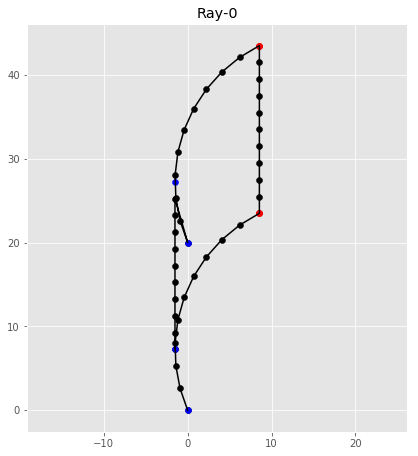

In [37]:
if __name__ == '__main__':
    #hbl_input( W, d, S, REFUS, REFUD, REFLS, REFLD, psi, phi )
    hbl = hbl_input( 25., 5., 20., 0.8, 0.8, 0.2, 0.2, 70., 30. )
    #hbl = hbl_input( 25., 0., 20., 0.8, 0.8, 0.2, 0.2, 70., 30. )

    # W：スラット幅 (mm)
    # d：スラット高さ (mm) 
    # S：スラット間隔 (mm) 
    # REFUS：スラット材上面の日射反射率（鏡面反射成分）
    # REFUD：スラット材上面の日射反射率（拡散反射成分）
    # REFLS：スラット材下面の日射反射率（鏡面反射成分）
    # REFLD：スラット材下面の日射反射率（拡散反射成分）
    # psi：スラット角 (°) 
    # phi：プロファイル角 (°)

    K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)

    A = slat_edge_position(hbl)[0]
    B = slat_edge_position(hbl)[1]
    C = slat_edge_position(hbl)[2]
    D = slat_edge_position(hbl)[3]
    E = slat_edge_position(hbl)[4]
    F = slat_edge_position(hbl)[5]
    
    O = slat_circle(hbl, A, B, E)[0]
    r = slat_circle(hbl, A, B, E)[1]
    theta = slat_circle(hbl, A, B, E)[2]

    Ad = slat_additional_position(hbl, O, r, A, B)[0]
    Bd = slat_additional_position(hbl, O, r, A, B)[1]
    Cd = slat_additional_position(hbl, O, r, A, B)[2]
    Dd = slat_additional_position(hbl, O, r, A, B)[3]

    if hbl.d == 0: q = position_vector_flat_q(hbl, K)
    elif hbl.d != 0: q = position_vector_curve_q(hbl, K, O, r, theta, A, B, C, D, Ad, Bd, Cd, Dd)

    print('A=', A)
    print('B=', B)
    print('Ad=', Ad)
    print('Bd=', Bd)
    print('E=', E)
    print('O=', O)
    print('r=', r)
    print('θ=', theta)

    l = 2
    ax = np.empty(l, dtype = np.object)
    fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2)))
    plt.style.use('ggplot')

    for ll in range(l-1):   
        ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
        ax[ll].set_title('Ray-' + str(ll))
        ax[ll].scatter(q[:, 0], q[:, 1], color='k')
        ax[ll].plot(q[:, 0], q[:, 1], color='k')
        ax[ll].scatter(A[0], A[1], color='b')
        ax[ll].scatter(B[0], B[1], color='r')
        ax[ll].scatter(C[0], C[1], color='r')
        ax[ll].scatter(D[0], D[1], color='b')
        ax[ll].scatter(Ad[0], Ad[1], color='b')
        ax[ll].scatter(Bd[0], Bd[1], color='r')
        ax[ll].scatter(Cd[0], Cd[1], color='r')
        ax[ll].scatter(Dd[0], Dd[1], color='b')
        plt.axis('equal')

    plt.show()

T+ 7.25714337867 0.0 87.2056379454 0.729342969918 [-1.5162825606140906, 7.2571433786744501]


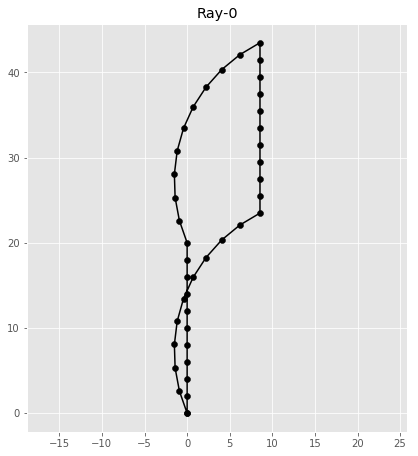

In [71]:
#4 スラット円弧の位置ベクトルのみ

S = 20.                              #スラット間隔(mm)
W = 25.                              #スラット幅(mm)
d = 5.                               #スラット高さ(mm)
psi = 70.                            #スラット角(°)
rho_upper = 0.8                      #スラット材上面の反射率(鏡面)
rho_lower = 0.2                      #スラット材下面の反射率(鏡面)
phi = 30.                            #プロファイル角(°)

M = 100                              #入射開口の微小線分要素分割数
K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)
Kall = np.sum(K)                     #領域境界の微小線分要素分割数(全境界)
L = 100                              #最大反射回数
#↓ここから
#スラット高さがある場合のスラット円弧の計算
if d != 0:
    cir_a = np.empty((3, 3), dtype=object)
    cir_b = np.empty((3), dtype=object)
    cir_l = np.empty((3), dtype=object)
    
    cir_a = np.array([[0., 0., 1.],
                      [W * np.cos(np.deg2rad(psi)), W * np.sin(np.deg2rad(psi)), 1.],
                      [((0.5 * W) ** 2. + d ** 2.) ** 0.5 * np.cos(np.arctan(d / (0.5 * W)) + np.deg2rad(psi)), 
                       ((0.5 * W) ** 2. + d ** 2.) ** 0.5 * np.sin(np.arctan(d / (0.5 * W)) + np.deg2rad(psi)), 1.]]) #外接円の3点の座標
    
    cir_b = -(cir_a[:, 0] ** 2 + cir_a[:, 1] ** 2.)

    cir_a = cir_a.astype(np.float64)
    cir_b = cir_b.astype(np.float64)
    cir_l = np.linalg.solve(cir_a, cir_b)
    
    cir_o =[- 0.5 * cir_l[0], - 0.5 * cir_l[1]] #円弧の原点の位置ベクトル
    cir_r = ((- 0.5 * cir_l[0]) ** 2. + (- 0.5 * cir_l[1]) ** 2. - cir_l[2]) ** 0.5

    cir_theta = np.rad2deg(4 * np.arctan(d / (0.5 * W))) #円弧の中心角
#↑ここまで確認

#↓ここは今検討中の場所、食い込み判定
    if psi > 0: #スラット角が正
        if cir_o[1] > cir_a[0][1]: #スラット角が0より大きく、円弧が食い込む
            point_Ad = [cir_o[0] - cir_r, cir_o[1]] #点A'の位置
            cir_theta1 = np.rad2deg(np.arcsin(cir_o[1] / cir_r))
            cir_theta2 = cir_theta - cir_theta1
            div_theta_ratio = cir_theta2 / cir_theta
            print("T+", cir_o[1], cir_a[0][1], cir_theta, div_theta_ratio, point_Ad)
        else:                      #スラット角が0より大きく、円弧が食い込まない
            point_Ad = [0., 0.] #点A'の位置            
            print("F+", cir_o[1], cir_a[0][1], cir_theta, point_Ad)
    elif psi < 0:
        if cir_o[1] > cir_a[0][1]:
            print("T-", cir_o[1], cir_a[0][1])
        else:
            print("F-", cir_o[1], cir_a[0][1])
#↑ここは今検討中の場所、食い込み判定
    
#領域境界の分割要素の始点の位置ベクトル
q = np.empty((Kall + 1, 2), dtype=object)
for i in range(Kall + 1):
    if d == 0: #平板
        if i <= K[0]:                            #A-B間
            q[i] = [W / K[0] * i * np.cos(np.deg2rad(psi)), 
                    W / K[0] * i * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] - W / K[2] * (i - K[0] - K[1]) * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] - W / K[2] * (i - K[0] - K[1]) * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
    elif d != 0: #円弧
        if i <= K[0]:                            #A-B間
            if psi > 0:
                if cir_o[1] <= cir_a[0][1]:
                    q[i] = [cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i)), 
                            cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i))]
                elif cir_o[1] > cir_a[0][1]:
                    if i / K[0] + 1. <= div_theta_ratio:
                        q[i] = [cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i)), 
                                cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i))]
                        q[i+1]=
                    else:
                        q[i] = [cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i)), 
                                cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i))] #要検討                    
            elif psi < 0:
                    q[i] = [cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i)), 
                            cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i))] #要検討            
            else:
                    q[i] = [cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i)), 
                            cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) - np.deg2rad(cir_theta / K[0] * i))] #要検討                
        elif i <= (K[0] + K[1]):                 #B-C間
            q[i] = [q[K[0]][0], 
                    q[K[0]][1] + S / K[1] * (i - K[0])]
        elif i <= (K[0] + K[1] + K[2]):          #C-D間
            q[i] = [q[K[0] + K[1]][0] + cir_o[0] - cir_r * np.cos((np.arctan(cir_o[1] / cir_o[0])) + \
                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1] - K[2]))) - W * np.cos(np.deg2rad(psi)), 
                    q[K[0] + K[1]][1] + cir_o[1] - cir_r * np.sin((np.arctan(cir_o[1] / cir_o[0])) + \
                    np.deg2rad(cir_theta / K[2] * (i - K[0] - K[1] - K[2]))) - W * np.sin(np.deg2rad(psi))]
        elif i <= (K[0] + K[1] + K[2] + K[3]):    #D-A間
            q[i] = [q[K[0] + K[1] + K[2]][0], 
                    q[K[0] + K[1] + K[2]][1] - S / K[3] * (i - K[0] - K[1] - K[2])]
        
#グラフの描画
#gx = np.empty((M, L, 2), dtype=object)
#gy = np.empty((M, L, 2), dtype=object)
#for ll in range(l):
#    for m in range(0, M, 2):
#        gx[m][ll] = [p[m][ll][0], p[m][ll + 1][0]]
#        gy[m][ll] = [p[m][ll][1], p[m][ll + 1][1]]    

l = 2
ax = np.empty(l, dtype = np.object) #
fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2))) #
#fig = plt.figure(figsize = (10, 10))
plt.style.use('ggplot')
#plt.tick_params(labelsize=10)

for ll in range(l-1):   
    ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
    #ax = fig.add_subplot(1, 1, 1)
    ax[ll].set_title('Ray-' + str(ll))
    ax[ll].scatter(q[:, 0], q[:, 1], color='k')
    ax[ll].plot(q[:, 0], q[:, 1], color='k')
#    for m in range(M):
#        ax[ll].plot(gx[m][ll], gy[m][ll], color='C0', linewidth=0.5)
    #ax.scatter(p[:, 1, 0], p[:, 1, 1], color='C0')
    plt.axis('equal')

plt.show()

#-45より小さいスラット角度



In [3]:
a = np.rad2deg(np.arctan(1))
b = np.rad2deg(np.arctan(-1))

print(a,b)

45.0 -45.0


In [ ]:
40.0625
0.0512 0.5056